## Setup enviroment

In [1]:
import os
import gc
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append(r'C:\Users\jeanr\Documents\projetos\classificacao\lending-club\global')
from util import *
import optuna
import shap
import json
import joblib

sns.set(style='whitegrid')

c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read train, validation and calibration data

In [2]:
train_df = pd.read_parquet('../data/processed/abt_train.parquet')
validation_df = pd.read_parquet('../data/processed/abt_validation.parquet')
calibration_df = pd.read_parquet('../data/processed/abt_calibration.parquet')

In [3]:
categorical_column_names = train_df.select_dtypes(include=['category']).columns
categorical_column_names

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type'],
      dtype='object')

In [4]:
cat_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type']

## Train, Validation, Test Split

In [5]:
target = 'default'

# Input variables and Target dataframes
X_train, y_train = train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (88744, 100) (88744,)
Validation shape:  (264688, 100) (264688,)
Calibration shape:  (66173, 100) (66173,)


In [6]:
selected_features = None
with open('../artifacts/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'income_to_funded_ratio', 'debt_to_income_ratio', 'funded_amnt_per_income', 'fico_avg', 'delinquency_ratio', 'int_rate_to_income_ratio', 'public_records_impact', 'pct_active_bc', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type']


## Perform Optuna Hyperparameter Tuning

In [7]:
best_params = None

In [8]:
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 150, 500, 1000]),
        'max_depth': trial.suggest_categorical('depth', [4, 8, 12]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        'cat_features': cat_features,
        'verbose': 0
    }

    model = CatBoostClassifier(**params, eval_metric='PRAUC:use_weights=false')
    tscv = TimeSeriesSplit(n_splits=4)
    avg_precision_scores = []

    for train_index, val_index in tscv.split(X_train[selected_features]):
        X_train_fold, X_val_fold = X_train[selected_features].iloc[train_index], X_train[selected_features].iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=100)
        #model.fit(X_train_fold, y_train_fold, early_stopping_rounds=300)
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        avg_precision_scores.append(average_precision_score(y_val_fold, y_pred_fold))

    return np.mean(avg_precision_scores)

study = optuna.create_study(direction='maximize')

# Optimize for 1 hour 
# print('Tuning the model...')
#study.optimize(objective, timeout=3600)

# Optimize for 1 minute
print('Tuning the model...')
#study.optimize(objective, timeout=60*5, n_trials=10)
study.optimize(objective, timeout=60, n_trials=10, n_jobs=-1)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-04 19:19:43,841] A new study created in memory with name: no-name-145277dc-03d3-4281-8f4d-3501afcd501f


Tuning the model...


[I 2025-02-04 19:22:01,742] Trial 8 finished with value: 0.30219367476516296 and parameters: {'iterations': 50, 'depth': 4, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.0026449543159228913, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 8 with value: 0.30219367476516296.
[I 2025-02-04 19:22:25,107] Trial 3 finished with value: 0.33252476145821824 and parameters: {'iterations': 50, 'depth': 8, 'colsample_bylevel': 1.0, 'subsample': 0.4, 'learning_rate': 0.03653468102554954, 'auto_class_weights': 'Balanced'}. Best is trial 3 with value: 0.33252476145821824.
[I 2025-02-04 19:24:09,723] Trial 7 finished with value: 0.26645328611444424 and parameters: {'iterations': 150, 'depth': 4, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.0011131454553555873, 'auto_class_weights': 'Balanced'}. Best is trial 3 with value: 0.33252476145821824.
[I 2025-02-04 19:24:21,110] Trial 5 finished with value: 0.29137811214361103 and parameters: {'iterations': 150, 'depth':

Best parameters: {'iterations': 150, 'depth': 8, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.028142722502155278, 'auto_class_weights': 'SqrtBalanced'}


In [9]:
# Save the best parameters to a JSON file
print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))
best_params_path = '../artifacts/best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

Saving the best parameters to a JSON file...
  {
    "iterations": 150,
    "depth": 8,
    "colsample_bylevel": 1.0,
    "subsample": 0.8,
    "learning_rate": 0.028142722502155278,
    "auto_class_weights": "SqrtBalanced"
}


## Retrain the Model with the Best Parameters

In [13]:

model_tunned = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, random_state=125)
model_tunned.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_tunned = model_tunned.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.3168181	test: 0.3372960	best: 0.3372960 (0)	total: 108ms	remaining: 16.1s
1:	learn: 0.3213358	test: 0.3481521	best: 0.3481521 (1)	total: 234ms	remaining: 17.3s
2:	learn: 0.3269926	test: 0.3532608	best: 0.3532608 (2)	total: 357ms	remaining: 17.5s
3:	learn: 0.3280822	test: 0.3536641	best: 0.3536641 (3)	total: 481ms	remaining: 17.5s
4:	learn: 0.3320383	test: 0.3551484	best: 0.3551484 (4)	total: 604ms	remaining: 17.5s
5:	learn: 0.3339968	test: 0.3572728	best: 0.3572728 (5)	total: 717ms	remaining: 17.2s
6:	learn: 0.3347061	test: 0.3576023	best: 0.3576023 (6)	total: 836ms	remaining: 17.1s
7:	learn: 0.3344988	test: 0.3574645	best: 0.3576023 (6)	total: 954ms	remaining: 16.9s
8:	learn: 0.3354934	test: 0.3565688	best: 0.3576023 (6)	total: 1.06s	remaining: 16.7s
9:	learn: 0.3358080	test: 0.3565049	best: 0.3576023 (6)	total: 1.18s	remaining: 16.5s
10:	learn: 0.3368604	test: 0.3573166	best: 0.3576023 (6)	total: 1.31s	remaining: 16.6s
11:	learn: 0.3372971	test: 0.3576731	best: 0.3576731 

In [14]:
# Model metrics report
clf_metric_report(y_pred_tunned, y_validation)

Evaluating the model...
ROC AUC: 0.709077015785301
Brier Score: 0.15468651880235867
Average Precision: 0.37000465192897974
Log Loss: 0.4795318978279154


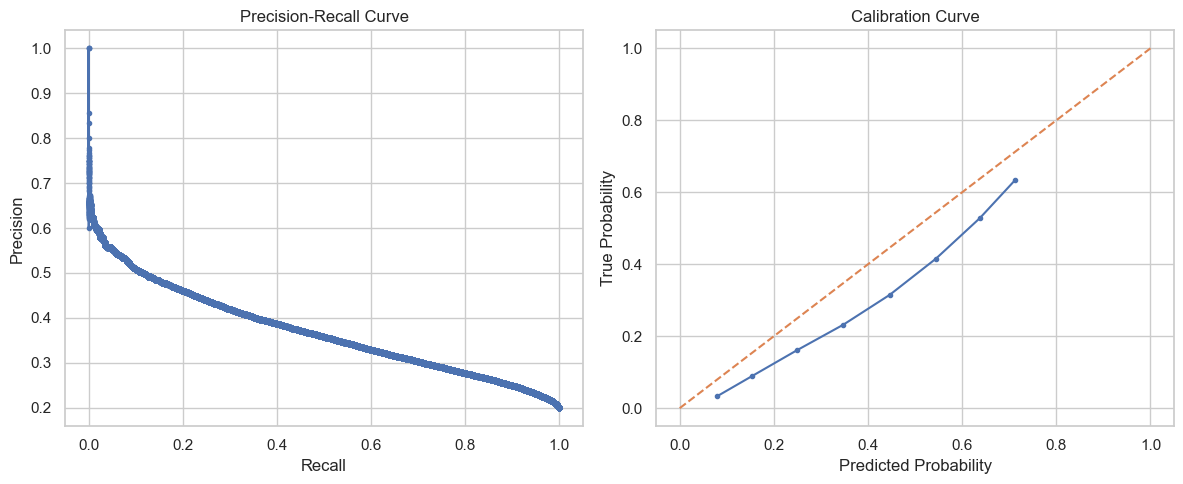

In [15]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_tunned, y_validation)

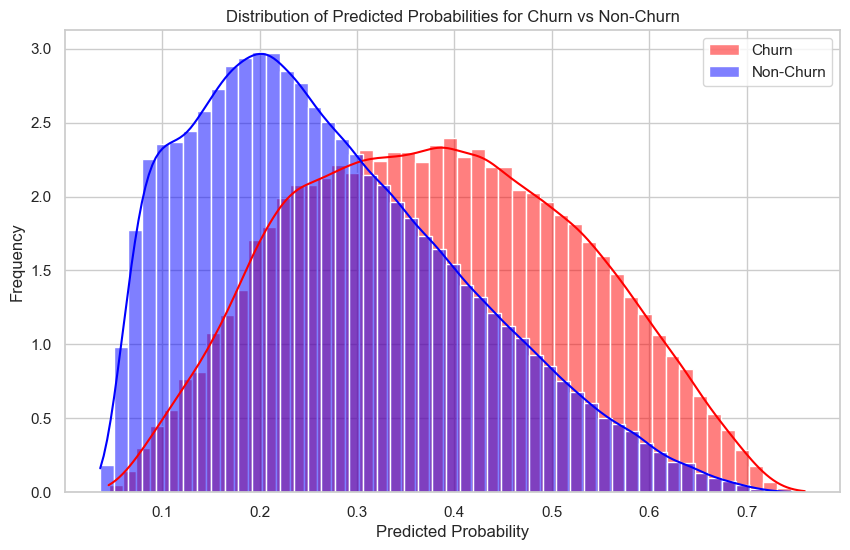

In [16]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_tunned, y_validation)

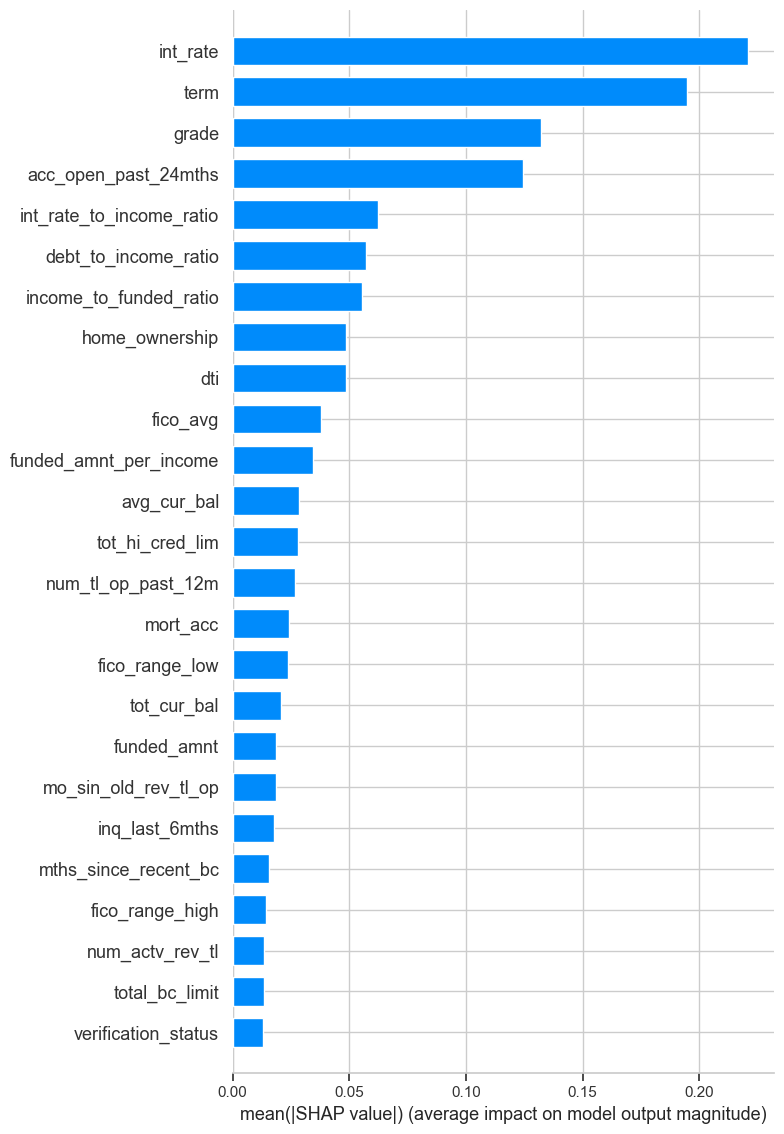

In [17]:
# SHAP Values
shape_explainer = shap.Explainer(model_tunned)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

## Comparing the models

In [18]:
# Load the baseline and feature selection models
baseline_model_path = '../artifacts/baseline_model.joblib'
feat_selection_model_path = '../artifacts/feat_selection_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)

# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.7075410527161095
Brier Score: 0.22000429047434117
Average Precision: 0.3691383629014476
Log Loss: 0.6272075914622884

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7108839790201789
Brier Score: 0.2026929258307413
Average Precision: 0.3740644390009613
Log Loss: 0.5875735052856713

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.709077015785301
Brier Score: 0.15468651880235867
Average Precision: 0.37000465192897974
Log Loss: 0.4795318978279154


In [19]:
# Save the model trained with selected features
tunned_model_path = '../artifacts/tunned_model.joblib'
joblib.dump(model_tunned, tunned_model_path)

print(f"Baseline model saved to: {tunned_model_path}")

Baseline model saved to: ../artifacts/tunned_model.joblib
